# Section 3.3: Critical factors in determining the neural entrainment to tACS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pickle
import simnibs
import os, subprocess
import scipy
import plot_functions
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import scipy.stats as stats

# Figure 5(a): Correlation between PLV and E-field magnitude

In [2]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
# Load normals and centers of 1000 elements
dataPath     = 'data_paper/Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo  = np.load(dataPath, allow_pickle=True).item()
cell_normals = popCellInfo['cell_normals']        # shape=(1000, 3)
cell_origins = popCellInfo['cell_origins'] * 1e3  # shape=(1000, 3), *1e3 for mm to μm
num_elements = len(cell_origins)
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])
# Linear interpolation for smoothing the data points
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], pph_roi_surf, function='linear')
pph_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], fr_roi_surf, function='linear')
fr_roi_surf_interp  = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Calculate the E-field direction relative to model neurons
list_theta_layer5, list_phi_layer5 = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(Evectors, cell_normals)
index_upward   = list_theta_layer5 < 90
index_downward = list_theta_layer5 > 90


# scale by a factor of 2, eaqualing to 4mA, 10Hz tACS
Evectors = Evectors * 2
# 1. E-field magnitude
Emagnitudes        = np.linalg.norm(Evectors, axis=1) 
rbf                = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], Emagnitudes, function='linear')
Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# 2. E-field normal component
Enormals           = np.array([np.dot(Evectors[i], cell_normals[i]) / np.linalg.norm(cell_normals[i]) for i in range(len(cell_normals))])
rbf                = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], Enormals, function='linear')
Enormals_interp    = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# 3. E-field tangential component
Etangents          = np.array([np.sqrt(Emagnitudes[i]**2 - Enormals[i]**2) for i in range(len(cell_normals))])
rbf                = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], Etangents, function='linear')
Etangents_interp   = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

upward + downward E-field: R2=0.9410042630090553, pvalue=0.0
  upward E-field: R2=0.1022263046770026, pvalue=1.322639209735538e-08
downward E-field: R2=0.11866298453763027, pvalue=7.050774547571207e-21


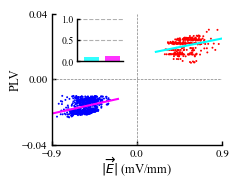

In [3]:
'''Correlation between PLV and EF magnitude'''
value_min, value_max = -0.9, 0.9
xUpward, xDownward = Emagnitudes[index_upward], Emagnitudes[index_downward]
yUpward, yDownward = plv_roi_surf[index_upward], plv_roi_surf[index_downward]
xDownward, yDownward = -xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(value_min, value_max, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0.2, value_max, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(value_min, -0.2, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")


# plot figures
fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.7))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-0.9, 0.9)
ax.set_xticks(np.arange(-0.9, 0.91, 0.9))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))
ax.set_xlabel(r'$|\overrightarrow{E}|$ (mV/mm)', fontsize=9, labelpad=-2.5, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=9, labelpad=0, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=8, width=1, length=3, labelfontfamily='times new roman')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4a.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 5(b): Correlation between PLV and E-field tangentials

upward + downward E-field: R2=0.7748913178375566, pvalue=0.0
  upward E-field: R2=0.05310278402333794, pvalue=5.287101338146962e-05
downward E-field: R2=0.37586207655616577, pvalue=2.8156391819701818e-73


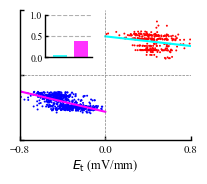

In [5]:
'''Correlation between PLV and EF tangentials'''
value_min, value_max = -0.8, 0.8
xUpward, xDownward = Etangents[index_upward], Etangents[index_downward]
yUpward, yDownward = plv_roi_surf[index_upward], plv_roi_surf[index_downward]
xDownward, yDownward = -xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(value_min, value_max, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0, value_max, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(value_min, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.7))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
# ax.plot(xfit, yfit, lw=1.5, color='k', ls='--', label='Linear')
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-0.8, 0.8)
ax.set_xticks(np.arange(-0.8, 0.81, 0.8))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))
ax.set_xlabel(r'$E_{\mathrm{t}}$ (mV/mm)', fontsize=9, labelpad=2, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=9, labelpad=0, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=8, width=1, length=3, labelfontfamily='times new roman')
ax.set_yticklabels([])
ax.set_ylabel('')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4c.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 5(c): Correlation between PLV and E-field normals

upward + downward E-field: R2=0.8615638013364995, pvalue=0.0
  upward E-field: R2=0.8301915709145103, pvalue=1.5740602694899242e-117
downward E-field: R2=0.8491029806957875, pvalue=4.974607776893506e-288


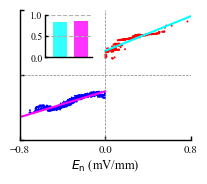

In [6]:
'''Correlation between PLV and EF normals'''
value_min, value_max = -0.8, 0.8
xUpward, xDownward = Enormals[index_upward], Enormals[index_downward]
yUpward, yDownward = plv_roi_surf[index_upward], plv_roi_surf[index_downward]
xDownward, yDownward = xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(value_min, value_max, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0, value_max, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(value_min, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.7))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
# ax.plot(xfit, yfit, lw=1.5, color='k', ls='--', label='Linear')
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-0.8, 0.8)
ax.set_xticks(np.arange(-0.8, 0.81, 0.8))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))
ax.set_xlabel(r'$E_{\mathrm{n}}$ (mV/mm)', fontsize=9, labelpad=2, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=9, labelpad=0, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=8, width=1, length=3, labelfontfamily='times new roman')
ax.set_yticklabels([])
ax.set_ylabel('')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4b.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 5(d): Correlation between PLV and somatic polarization

In [36]:
# Load somatic polarization
data = pickle.load(open('data_paper/L5PC_Clone4_polarization_ROISurf_uniform_tACS2mA10Hz_EFAtSoma.p', 'rb'))
polarization_uniform = np.array([item[1] for item in data])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], polarization_uniform, function='linear')
polarization_uniform_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load PLV and PPh, fr (1000 elements)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data     = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

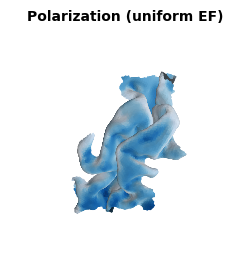

In [41]:
tempdata   = polarization_uniform_interp
value_min, value_max = 0, 0.1
color_numPoint = 30000
color_name     = 'Blues'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Polarization (uniform EF)', fontsize=10, weight='bold')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_polarization_uniformEF_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)
# scipy.io.savemat(dataPath, data)

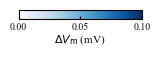

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(1.06, 0.12))
ax.axis('off')
cmap = plt.get_cmap('Blues', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 1.5, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.05, 0.1])
cbar.ax.set_xlabel('$\Delta V_{\mathrm{m}}$ (mV)', fontdict={'family': 'times new roman', 'fontsize': 8}, labelpad=1)
cbar.ax.tick_params(direction='in', pad=2, length=2, labelfontfamily='times new roman', labelsize=7)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4d-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

upward + downward E-field: R2=0.8714609570812307, pvalue=0.0
  upward E-field: R2=0.8343440490040795, pvalue=3.829271694435295e-119
downward E-field: R2=0.864282279337098, pvalue=4.672786034547919e-304


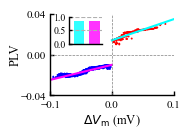

In [10]:
'''Correlation between PLV and EF tangentials'''
value_min, value_max = -0.1, 0.1
xUpward, xDownward   = polarization_uniform[index_upward], polarization_uniform[index_downward]
yUpward, yDownward   = plv_roi_surf[index_upward], plv_roi_surf[index_downward]
xDownward, yDownward = -xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(value_min, value_max, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0, value_max, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(value_min, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(1.59, 1.06))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-0.1, 0.1)
ax.set_xticks(np.arange(-0.1, 0.11, 0.1))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))
ax.set_xlabel(r'$\Delta V_{\mathrm{m}}$ (mV)', fontsize=9, labelpad=2, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=9, labelpad=-1, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=8, width=1, length=3, labelfontfamily='times new roman')
# ax.set_yticklabels([])
# ax.set_ylabel('')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4d-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 5(e): Correlation between PLV and effective polarization length Ld

In [44]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
# Load normals and centers of 1000 elements
dataPath     = 'data_paper/Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo  = np.load(dataPath, allow_pickle=True).item()
cell_normals = popCellInfo['cell_normals']        # shape=(1000, 3)
cell_origins = popCellInfo['cell_origins'] * 1e3  # shape=(1000, 3), *1e3 for mm to μm
num_elements = len(cell_origins)
# Load cell coordinates and compute the Lp
cell_coords = np.load('data_paper/L5PC_Clone4_coordinates_sectionAndSegment.npy', allow_pickle=True).item()
segment_startAndEnd = np.vstack((cell_coords['segment_coords']['cell_segment_coordinates_start'], \
                                 cell_coords['segment_coords']['cell_segment_coordinates_end']))
list_theta_layer5, list_phi_layer5 = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(Evectors, cell_normals)
list_phi_layer5[list_phi_layer5 < 0] += 360
index_upward   = list_theta_layer5 < 90
index_downward = list_theta_layer5 > 90
effective_polarization_length = np.array([plot_functions.calc_cell_effective_polarization_length_at_given_direction(segment_startAndEnd, \
                list_theta_layer5[i], list_phi_layer5[i], angle='degree') for i in range(len(list_theta_layer5))])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], effective_polarization_length, function='linear')
effective_polarization_length_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

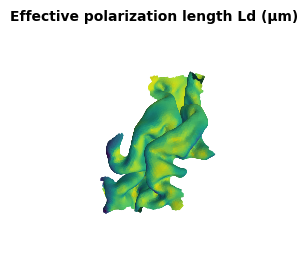

In [45]:
tempdata   = effective_polarization_length_interp
value_min, value_max = 500, 1850
color_numPoint = 30000
color_name     = 'viridis'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color     = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Effective polarization length Ld (μm)', fontsize=10, weight='bold')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_effecctive_polarization_length_L5PCClone4_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)
# scipy.io.savemat(dataPath, data)

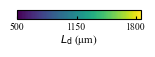

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1.06, 0.12))
ax.axis('off')
cmap = plt.get_cmap('viridis', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 1.5, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([500, 1150, 1800])
cbar.ax.set_xlabel('$L_{\mathrm{d}}$ (μm)', fontdict={'family': 'times new roman', 'fontsize': 8}, labelpad=1)
cbar.ax.tick_params(direction='in', pad=2, length=2, labelfontfamily='times new roman', labelsize=7)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4e-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

upward + downward E-field: R2=0.9707093268209667, pvalue=0.0
  upward E-field: R2=0.3155249613170432, pvalue=1.637106838175661e-26
downward E-field: R2=0.47949620495994005, pvalue=9.014286618600938e-101


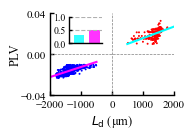

In [14]:
value_min, value_max = -2000, 2000
xUpward, xDownward   = effective_polarization_length[index_upward], effective_polarization_length[index_downward]
yUpward, yDownward   = plv_roi_surf[index_upward], plv_roi_surf[index_downward]
xDownward, yDownward = -xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(value_min, value_max, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(500, value_max, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(value_min, -500, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(1.59, 1.06))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-2000, 2000)
ax.set_xticks(np.arange(-2e3, 2e3+1, 1e3))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))
ax.set_xlabel(r'$L_{\mathrm{d}}$ (μm)', fontsize=9, labelpad=2, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=9, labelpad=-1, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=8, width=1, length=3, labelfontfamily='times new roman')
# ax.set_yticklabels([])
# ax.set_ylabel('')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4e-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S6: E-field normal and tangential distributions in L5 SOI

In [4]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
# Load normals and centers of 1000 elements
dataPath     = 'data_paper/Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo  = np.load(dataPath, allow_pickle=True).item()
cell_normals = popCellInfo['cell_normals']        # shape=(1000, 3)
cell_origins = popCellInfo['cell_origins'] * 1e3  # shape=(1000, 3), *1e3 for mm to μm
num_elements = len(cell_origins)

# scale by a factor of 2, eaqualing to 4mA, 10Hz tACS
Evectors = Evectors * 2
# 1. E-field magnitude
Emagnitudes        = np.linalg.norm(Evectors, axis=1)
rbf                = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], Emagnitudes, function='linear')
Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# 2. E-field normal component
Enormals           = np.array([np.dot(Evectors[i], cell_normals[i]) / np.linalg.norm(cell_normals[i]) for i in range(len(cell_normals))])
rbf                = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], Enormals, function='linear')
Enormals_interp    = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# 3. E-field tangential component
Etangents          = np.array([np.sqrt(Emagnitudes[i]**2 - Enormals[i]**2) for i in range(len(cell_normals))])
rbf                = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], Etangents, function='linear')
Etangents_interp   = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

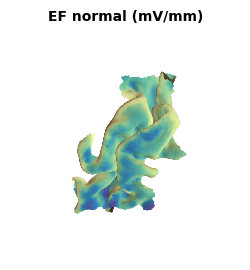

In [9]:
tempdata   = Enormals_interp
value_min, value_max = -0.7, 0.7
color_numPoint = 30000
color_name     = 'Spectral_r'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color     = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('EF normal (mV/mm)', fontsize=10, weight='bold')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_EF_normal_component_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)
# scipy.io.savemat(dataPath, data)

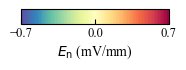

In [18]:
fig, ax = plt.subplots(1,1, figsize=(0.95, 0.185))
ax.axis('off')
cmap = plt.get_cmap('Spectral_r', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.7, vmax=0.7))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([-0.7, 0, 0.7])
cbar.ax.tick_params(direction='in', pad=3, labelfontfamily='times new roman', labelsize=9)
cbar.set_label(r'$E_{\mathrm{n}}$ (mV/mm)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4Sa-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

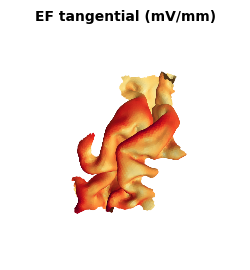

In [27]:
tempdata   = Etangents_interp
value_min, value_max = 0, 0.8
color_numPoint = 30000
color_name     = 'YlOrRd'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color     = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('EF tangential (mV/mm)', fontsize=10, weight='bold')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_EF_tangential_component_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)
# scipy.io.savemat(dataPath, data)

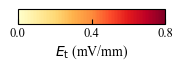

In [20]:
fig, ax = plt.subplots(1,1, figsize=(0.95, 0.185))
ax.axis('off')
cmap = plt.get_cmap('YlOrRd', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=0.8))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.4, 0.8])
cbar.ax.tick_params(direction='in', pad=3, labelfontfamily='times new roman', labelsize=9)
cbar.set_label(r'$E_{\mathrm{t}}$ (mV/mm)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4Sb-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S7 top: normalized E-field normal, somatic polarization, Ld

In [5]:
# define the 410 EF directions
list_theta = np.arange(0, 181, 10)
list_phi = np.arange(0, 360, 15)
list_410_directions = []
list_410_directions.append([list_theta[0], 0])
for i in range(1, list_theta.shape[0] - 1):
    for j in range(list_phi.shape[0]):
        list_410_directions.append([list_theta[i], list_phi[j]])
list_410_directions.append([list_theta[-1], 0])

list_theta = np.arange(0, 181, 10)
list_phi   = np.arange(0, 361, 15)
list_theta = np.deg2rad(list_theta - 90)
list_phi   = np.deg2rad(list_phi - 180)
'''1 Load PLV data'''
# Load data: neural entrainment across the full range of possible field directions
dataPath = 'data_paper/L5PC_Clone4_PLV_sensitivity_to_Efield_410_directions_1mVmm_10Hz.p'
data_410_direction = pickle.load(open(dataPath, 'rb'))
plv_410_direction  = np.array([item[0] for item in data_410_direction])
print('PLV min = %.4f, PLV max = %.4f' % (plv_410_direction.min(), plv_410_direction.max()))

# Transfer list data to matrix data
matrix_plv = np.zeros((len(list_theta), len(list_phi)))
matrix_plv[0, :] += plv_410_direction[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_plv[i, j] = plv_410_direction[num]
        num += 1
    matrix_plv[i, -1] = plv_410_direction[num - len(list_phi) + 1]
matrix_plv[-1, :] += plv_410_direction[-1]
matrix_plv = np.hstack((matrix_plv[:,12:-1], matrix_plv[:,0:13]))
# Interpolate matrix plv to smooth data points
interp_func       = scipy.interpolate.interp2d(list_phi, list_theta, matrix_plv, kind='linear')
inter_phi         = np.linspace(list_phi[0], list_phi[-1], 360*2+1)
interp_theta      = np.linspace(list_theta[0], list_theta[-1], 180*2+1)
matrix_plv_interp = interp_func(inter_phi, interp_theta)

'''2 Load Enormal data'''
matrix_Enormal = np.zeros((len(list_theta), len(list_phi)))
matrix_Enormal[0, :] += np.cos(np.deg2rad(list_410_directions[0][0]))
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_Enormal[i, j] = np.cos(np.deg2rad(list_410_directions[num][0]))
        num += 1
    matrix_Enormal[i, -1] = np.cos(np.deg2rad(list_410_directions[num - len(list_phi) + 1][0]))
matrix_Enormal[-1, :] += np.cos(np.deg2rad(list_410_directions[-1][0]))
matrix_Enormal = np.hstack((matrix_Enormal[:,12:-1], matrix_Enormal[:,0:13]))
interp_func           = scipy.interpolate.interp2d(list_phi, list_theta, matrix_Enormal, kind='linear')
inter_phi             = np.linspace(list_phi[0], list_phi[-1], 360*2+1)
interp_theta          = np.linspace(list_theta[0], list_theta[-1], 180*2+1)
matrix_Enormal_interp = interp_func(inter_phi, interp_theta)

'''3 Load polarization data'''
data = pickle.load(open('data_paper/L5PC_Clone4_polarization_sensitivity_to_Efield_410_directions.p', 'rb'))
soma_polarization_410_directions = np.array([item[1] for item in data])
matrix_polarization = np.zeros((len(list_theta), len(list_phi)))
matrix_polarization[0, :] += soma_polarization_410_directions[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_polarization[i, j] = soma_polarization_410_directions[num]
        num += 1
    matrix_polarization[i, -1] = soma_polarization_410_directions[num - len(list_phi) + 1]
matrix_polarization[-1, :] += soma_polarization_410_directions[-1]
matrix_polarization = np.hstack((matrix_polarization[:,12:-1], matrix_polarization[:,0:13]))
# Interpolate matrix polarization to smooth data points
interp_func                = scipy.interpolate.interp2d(list_phi, list_theta, matrix_polarization, kind='linear')
inter_phi                  = np.linspace(list_phi[0], list_phi[-1], 360*2+1)
interp_theta               = np.linspace(list_theta[0], list_theta[-1], 180*2+1)
matrix_polarization_interp = interp_func(inter_phi, interp_theta)

'''4 Load Lp data'''
# Load cell coordinates and compute the Lp
cell_coords = np.load('data_paper/L5PC_Clone4_coordinates_sectionAndSegment.npy', allow_pickle=True).item()
segment_startAndEnd = np.vstack((cell_coords['segment_coords']['cell_segment_coordinates_start'], \
                                 cell_coords['segment_coords']['cell_segment_coordinates_end']))
effective_polarization_length_410_directions = np.array([plot_functions.calc_cell_effective_polarization_length_at_given_direction(segment_startAndEnd, \
                list_410_directions[i][0], list_410_directions[i][1], angle='degree') for i in range(len(list_410_directions))])
matrix_Lp = np.zeros((len(list_theta), len(list_phi)))
matrix_Lp[0, :] += effective_polarization_length_410_directions[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_Lp[i, j] = effective_polarization_length_410_directions[num]
        num += 1
    matrix_Lp[i, -1] = effective_polarization_length_410_directions[num - len(list_phi) + 1]
matrix_Lp[-1, :] += effective_polarization_length_410_directions[-1]
matrix_Lp = np.hstack((matrix_Lp[:,12:-1], matrix_Lp[:,0:13]))
# Interpolate Lp to smooth data points
interp_func      = scipy.interpolate.interp2d(list_phi, list_theta, matrix_Lp, kind='linear')
inter_phi        = np.linspace(list_phi[0], list_phi[-1], 360*2+1)
interp_theta     = np.linspace(list_theta[0], list_theta[-1], 180*2+1)
matrix_Lp_interp = interp_func(inter_phi, interp_theta)

PLV min = 0.0088, PLV max = 0.0370


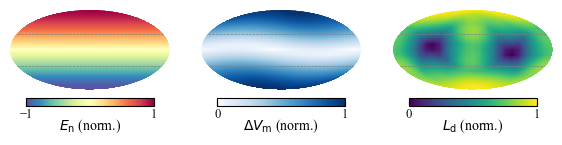

In [7]:
fig = plt.figure(figsize=(7, 5))
# a1: E-field normals
ax0  = fig.add_subplot(1, 3, 1, projection="mollweide")
ax   = ax0
norm = matplotlib.colors.Normalize(vmin=matrix_Enormal_interp.min(), vmax=matrix_Enormal_interp.max())
ax.pcolormesh(inter_phi, interp_theta, np.flip(matrix_Enormal_interp, axis=0), shading='auto', cmap='Spectral_r', norm=norm)
cmap     = plt.get_cmap('Spectral_r', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
mappable.set_array([])
cbar     = fig.colorbar(mappable, cax=ax.inset_axes([0.1, -0.2, 0.8, 0.1]), location='bottom', orientation='horizontal')
cbar.set_ticks([-1, 1])
cbar.ax.tick_params(direction='in', pad=2, labelfontfamily='times new roman', labelsize=9)
cbar.ax.set_xlabel('$E_{\mathrm{n}}$ (norm.)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=-2)

# b1: somatic polarizations
ax1  = fig.add_subplot(1, 3, 2, projection="mollweide")
ax   = ax1
norm = matplotlib.colors.Normalize(vmin=matrix_polarization_interp.min(), vmax=matrix_polarization_interp.max())
ax.pcolormesh(inter_phi, interp_theta, np.flip(matrix_polarization_interp, axis=0), shading='auto', cmap='Blues', norm=norm)
cmap     = plt.get_cmap('Blues', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar     = fig.colorbar(mappable, cax=ax.inset_axes([0.1, -0.2, 0.8, 0.1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 1])
cbar.ax.tick_params(direction='in', pad=2, labelfontfamily='times new roman', labelsize=9)
cbar.ax.set_xlabel('$\Delta V_{\mathrm{m}}$ (norm.)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=-2)

# c1: effective polarization lengths
ax2  = fig.add_subplot(1, 3, 3, projection="mollweide")
ax   = ax2
norm = matplotlib.colors.Normalize(vmin=matrix_Lp_interp.min(), vmax=matrix_Lp_interp.max())
ax.pcolormesh(inter_phi, interp_theta, np.flip(matrix_Lp_interp, axis=0), shading='auto', cmap='viridis', norm=norm)
cmap     = plt.get_cmap('viridis', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar     = fig.colorbar(mappable, cax=ax.inset_axes([0.1, -0.2, 0.8, 0.1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 1])
cbar.ax.tick_params(direction='in', pad=2, labelfontfamily='times new roman', labelsize=9)
cbar.ax.set_xlabel('$L_{\mathrm{d}}$ (norm.)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=-2)

for item in [ax0, ax1, ax2]:
    item.axis('off')
    item.axhline(np.deg2rad(30), ls='--', lw=0.5, color='gray')
    item.axhline(np.deg2rad(-30), ls='--', lw=0.5, color='gray')
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure5a1-c1.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S7 bottom: correlation between PLV and En, Vm, Ld

upward + downward E-field: R2=0.9501684381222849, pvalue=0.0
  upward E-field: R2=0.9283303725537149, pvalue=6.051309298144873e-144
downward E-field: R2=0.8960871515685485, pvalue=6.235726404117102e-124


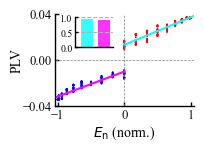

In [24]:
'''PLV - En'''
matrix_data = matrix_Enormal
value_min, value_max = matrix_data.min(), matrix_data.max()
matrix_data_norm = np.zeros_like(matrix_data)
for i in range(matrix_data.shape[0]):
    for j in range(matrix_data.shape[1]):
        # matrix_data_norm[i, j] = (matrix_data[i, j] - value_min) / (value_max - value_min)
        matrix_data_norm[i, j] = matrix_data[i, j]
xUpward, xDownward   = matrix_data_norm[:10].flatten(), matrix_data_norm[9:].flatten()
yUpward, yDownward   = matrix_plv[:10].flatten(), matrix_plv[9:].flatten()
xDownward, yDownward = xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(-1.05, 1.05, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0, 1.05, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(-1.05, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.2))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-1.05, 1.05)
ax.set_xticks(np.arange(-1, 1.1, 1))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))

ax.set_xlabel(r'$E_{\mathrm{n}}$ (norm.)', fontsize=10, labelpad=2, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=10, labelpad=-1, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=2, direction='in', labelsize=9, width=1, length=3, labelfontfamily='times new roman')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure5a2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

upward + downward E-field: R2=0.9514284349132371, pvalue=0.0
  upward E-field: R2=0.9185890764397755, pvalue=4.438277781625633e-137
downward E-field: R2=0.9076256698947331, pvalue=2.8412395712280167e-130


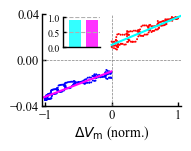

In [25]:
'''PLV - Vm'''
matrix_data = matrix_polarization
value_min, value_max = matrix_data.min(), matrix_data.max()
matrix_data_norm = np.zeros_like(matrix_data)
for i in range(matrix_data.shape[0]):
    for j in range(matrix_data.shape[1]):
        matrix_data_norm[i, j] = (matrix_data[i, j] - value_min) / (value_max - value_min)
xUpward, xDownward   = matrix_data_norm[:10].flatten(), matrix_data_norm[9:].flatten()
yUpward, yDownward   = matrix_plv[:10].flatten(), matrix_plv[9:].flatten()
xDownward, yDownward = -xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(-1.05, 1.05, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0, 1.05, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(-1.05, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.2))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-1.05, 1.05)
ax.set_xticks(np.arange(-1, 1.1, 1))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))

ax.set_xlabel(r'$\Delta V_{\mathrm{m}}$ (norm.)', fontsize=10, labelpad=2, fontfamily='times new roman')
# ax.set_ylabel('PLV', fontsize=10, labelpad=-1, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=2, direction='in', labelsize=9, width=1, length=3, labelfontfamily='times new roman')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure5b2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

upward + downward E-field: R2=0.9626867911775645, pvalue=0.0
  upward E-field: R2=0.6261999675037712, pvalue=6.488831561665079e-55
downward E-field: R2=0.685896486076518, pvalue=2.6447325032240527e-64


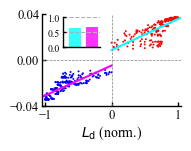

In [8]:
'''PLV - Ld'''
matrix_data = matrix_Lp
value_min, value_max = matrix_data.min(), matrix_data.max()
matrix_data_norm = np.zeros_like(matrix_data)
for i in range(matrix_data.shape[0]):
    for j in range(matrix_data.shape[1]):
        matrix_data_norm[i, j] = (matrix_data[i, j] - value_min) / (value_max - value_min)
xUpward, xDownward   = matrix_data_norm[:10].flatten(), matrix_data_norm[9:].flatten()
yUpward, yDownward   = matrix_plv[:10].flatten(), matrix_plv[9:].flatten()
xDownward, yDownward = -xDownward, -yDownward
# linear regression upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(-1.05, 1.05, 2000)
yfit = slope * xfit + intercept
R2   = r_value ** 2
print(f"upward + downward E-field: R2={R2}, pvalue={p_value}")
# linear regression upward
x, y = xUpward, yUpward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_upward = np.linspace(0, 1.05, 2000)
yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")
# linear regression downward
x, y = xDownward, yDownward
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit_downward = np.linspace(-1.05, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
R2_downward   = r_value ** 2
print(f"downward E-field: R2={R2_downward}, pvalue={p_value}")

# plot figures
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.2))
ax.scatter(xUpward, yUpward, s=2, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=2, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-1.05, 1.05)
ax.set_xticks(np.arange(-1, 1.1, 1))
ax.set_ylim(-0.04, 0.04)
ax.set_yticks(np.arange(-0.04, 0.041, 0.04))

ax.set_xlabel(r'$L_{\mathrm{d}}$ (norm.)', fontsize=10, labelpad=2, fontfamily='times new roman')
# ax.set_ylabel('PLV', fontsize=10, labelpad=-1, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=2, direction='in', labelsize=9, width=1, length=3, labelfontfamily='times new roman')

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1], [R2_upward, R2_downward], width=0.7, color=['cyan', 'magenta'], alpha=0.8)
ax_sub.set_xlim(-0.7, 1.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=2, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')

plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure5c2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')